In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_2d_cnn_only_conv_DO(conv_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid', 
                          activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [11]:
# for i in range(1, 5):
#     model = build_2d_cnn_only_conv(conv_num=i)
#     model.summary()
#     del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                780304    
Total params: 780,512
Trainable params: 780,512
Non-trainable params: 0
_______________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.7079 - acc: 0.4795
Epoch 00001: val_loss improved from inf to 1.39176, saving model to model/checkpoint/2D_CNN_1_only_conv_checkpoint/01-1.3918.hdf5
36805/36805 [==============================] - 9s 256us/sample - loss: 1.7073 - acc: 0.4797 - val_loss: 1.3918 - val_acc: 0.6080
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.3161 - acc: 0.6047
Epoch 00002: val_loss improved from 1.39176 to 1.28519, saving model to model/checkpoint/2D_CNN_1_only_conv_checkpoint/02-1.2852.hdf5
36805/36805 [==============================] - 9s 235us/sample - loss: 1.3162 - acc: 0.6046 - val_loss: 1.2852 - val_acc: 0.6406
Epoch 3/200
36544/36805 [============================>.] - ETA: 0s - loss: 1.1647 - acc: 0.6453
Epoch 00003: val_loss improved from 1.28519 to 1.21261, saving model to model/checkpoint/2D_C

36608/36805 [============================>.] - ETA: 0s - loss: 0.5145 - acc: 0.8373
Epoch 00027: val_loss did not improve from 1.04759
36805/36805 [==============================] - 9s 238us/sample - loss: 0.5145 - acc: 0.8373 - val_loss: 1.1133 - val_acc: 0.7286
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5050 - acc: 0.8396
Epoch 00028: val_loss did not improve from 1.04759
36805/36805 [==============================] - 9s 237us/sample - loss: 0.5049 - acc: 0.8396 - val_loss: 1.1010 - val_acc: 0.7375
Epoch 29/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.4985 - acc: 0.8419
Epoch 00029: val_loss did not improve from 1.04759
36805/36805 [==============================] - 9s 238us/sample - loss: 0.4988 - acc: 0.8418 - val_loss: 1.1189 - val_acc: 0.7345
Epoch 30/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.4915 - acc: 0.8435
Epoch 00030: val_loss did not improve from 1.04759
36805/36805 [=====================

Epoch 57/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.3710 - acc: 0.8802
Epoch 00057: val_loss did not improve from 1.04759
36805/36805 [==============================] - 9s 237us/sample - loss: 0.3708 - acc: 0.8802 - val_loss: 1.2080 - val_acc: 0.7421
Epoch 58/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.3658 - acc: 0.8832
Epoch 00058: val_loss did not improve from 1.04759
36805/36805 [==============================] - 9s 240us/sample - loss: 0.3659 - acc: 0.8832 - val_loss: 1.2207 - val_acc: 0.7438
Epoch 59/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3664 - acc: 0.8822
Epoch 00059: val_loss did not improve from 1.04759
36805/36805 [==============================] - 9s 241us/sample - loss: 0.3664 - acc: 0.8822 - val_loss: 1.2411 - val_acc: 0.7403
Epoch 60/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.3623 - acc: 0.8856
Epoch 00060: val_loss did not improve from 1.04759
36805/36805 [========

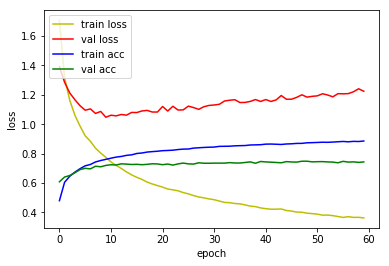

4815/4815 [==============================] - 1s 193us/sample - loss: 1.1291 - acc: 0.7078
Loss: 1.129059188734829 Accuracy: 0.70778817

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.7679 - acc: 0.4549
Epoch 00001: val_loss improved from inf to 1.32231, saving model to model/checkpoint/2D_CNN_2_only_conv_checkpoint/01-1.3223.hdf5
36805/36805 [==============================] - 11s 299us/sample - loss: 1.7678 - acc: 0.4549 - val_loss: 1.3223 - val_acc: 0.6224
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2485 - acc: 0.6264
Epoch 00002: val_loss improved from 1.32231 to 1.04643, saving model to model/checkpoint/2D_CNN_2_only_conv_checkpoint/02-1.0464.hdf5
36805/36805 [==============================] - 10s 269us/sample - loss: 1.2484 - acc: 0.6264 - val_loss: 1.0464 - val_acc: 0.7195
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9924 - acc: 0.7064
Epo

Epoch 25/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.2433 - acc: 0.9237
Epoch 00025: val_loss improved from 0.47992 to 0.47731, saving model to model/checkpoint/2D_CNN_2_only_conv_checkpoint/25-0.4773.hdf5
36805/36805 [==============================] - 10s 269us/sample - loss: 0.2432 - acc: 0.9238 - val_loss: 0.4773 - val_acc: 0.8952
Epoch 26/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.2388 - acc: 0.9234
Epoch 00026: val_loss did not improve from 0.47731
36805/36805 [==============================] - 10s 265us/sample - loss: 0.2385 - acc: 0.9237 - val_loss: 0.4793 - val_acc: 0.8915
Epoch 27/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.2344 - acc: 0.9273
Epoch 00027: val_loss improved from 0.47731 to 0.47032, saving model to model/checkpoint/2D_CNN_2_only_conv_checkpoint/27-0.4703.hdf5
36805/36805 [==============================] - 10s 266us/sample - loss: 0.2347 - acc: 0.9272 - val_loss: 0.4703 - val_acc: 0.8959


36800/36805 [============================>.] - ETA: 0s - loss: 0.1390 - acc: 0.9564
Epoch 00053: val_loss did not improve from 0.46377
36805/36805 [==============================] - 10s 265us/sample - loss: 0.1390 - acc: 0.9564 - val_loss: 0.4852 - val_acc: 0.8980
Epoch 54/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1414 - acc: 0.9554
Epoch 00054: val_loss did not improve from 0.46377
36805/36805 [==============================] - 10s 267us/sample - loss: 0.1414 - acc: 0.9553 - val_loss: 0.4813 - val_acc: 0.9012
Epoch 55/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.1365 - acc: 0.9569
Epoch 00055: val_loss did not improve from 0.46377
36805/36805 [==============================] - 10s 268us/sample - loss: 0.1369 - acc: 0.9568 - val_loss: 0.4924 - val_acc: 0.9012
Epoch 56/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1311 - acc: 0.9589
Epoch 00056: val_loss did not improve from 0.46377
36805/36805 [==================

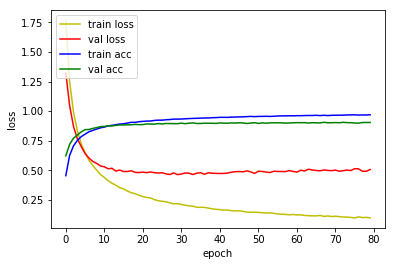

4815/4815 [==============================] - 1s 225us/sample - loss: 0.5591 - acc: 0.8623
Loss: 0.5590534259968457 Accuracy: 0.8623053

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.8430 - acc: 0.4189
Epoch 00001: val_loss improved from inf to 1.31392, saving model to model/checkpoint/2D_CNN_3_only_conv_checkpoint/01-1.3139.hdf5
36805/36805 [==============================] - 12s 328us/sample - loss: 1.8421 - acc: 0.4192 - val_loss: 1.3139 - val_acc: 0.6126
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.2784 - acc: 0.6049
Epoch 00002: val_loss improved from 1.31392 to 0.98432, saving model to model/checkpoint/2D_CNN_3_only_conv_checkpoint/02-0.9843.hdf5
36805/36805 [==============================] - 11s 292us/sample - loss: 1.2780 - acc: 0.6048 - val_loss: 0.9843 - val_acc: 0.7277
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.9880 - acc: 0.7018
Epo

Epoch 24/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.2152 - acc: 0.9322
Epoch 00024: val_loss did not improve from 0.28396
36805/36805 [==============================] - 11s 289us/sample - loss: 0.2149 - acc: 0.9324 - val_loss: 0.2920 - val_acc: 0.9280
Epoch 25/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.2076 - acc: 0.9346
Epoch 00025: val_loss improved from 0.28396 to 0.28197, saving model to model/checkpoint/2D_CNN_3_only_conv_checkpoint/25-0.2820.hdf5
36805/36805 [==============================] - 11s 290us/sample - loss: 0.2081 - acc: 0.9344 - val_loss: 0.2820 - val_acc: 0.9299
Epoch 26/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2066 - acc: 0.9344
Epoch 00026: val_loss did not improve from 0.28197
36805/36805 [==============================] - 11s 291us/sample - loss: 0.2065 - acc: 0.9344 - val_loss: 0.2844 - val_acc: 0.9299
Epoch 27/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1977 

Epoch 52/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1239 - acc: 0.9592
Epoch 00052: val_loss did not improve from 0.26507
36805/36805 [==============================] - 11s 292us/sample - loss: 0.1238 - acc: 0.9593 - val_loss: 0.2685 - val_acc: 0.9411
Epoch 53/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1250 - acc: 0.9596
Epoch 00053: val_loss did not improve from 0.26507
36805/36805 [==============================] - 11s 286us/sample - loss: 0.1251 - acc: 0.9595 - val_loss: 0.2740 - val_acc: 0.9401
Epoch 54/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.1204 - acc: 0.9598
Epoch 00054: val_loss did not improve from 0.26507
36805/36805 [==============================] - 11s 289us/sample - loss: 0.1208 - acc: 0.9598 - val_loss: 0.2771 - val_acc: 0.9390
Epoch 55/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1180 - acc: 0.9618
Epoch 00055: val_loss did not improve from 0.26507
36805/36805 [=====

Epoch 82/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0941 - acc: 0.9680
Epoch 00082: val_loss did not improve from 0.26507
36805/36805 [==============================] - 11s 288us/sample - loss: 0.0940 - acc: 0.9680 - val_loss: 0.2805 - val_acc: 0.9450
Epoch 83/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0879 - acc: 0.9718
Epoch 00083: val_loss did not improve from 0.26507
36805/36805 [==============================] - 11s 286us/sample - loss: 0.0878 - acc: 0.9718 - val_loss: 0.2821 - val_acc: 0.9427
Epoch 84/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0883 - acc: 0.9702
Epoch 00084: val_loss did not improve from 0.26507
36805/36805 [==============================] - 11s 288us/sample - loss: 0.0884 - acc: 0.9702 - val_loss: 0.2846 - val_acc: 0.9441
Epoch 85/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0867 - acc: 0.9723
Epoch 00085: val_loss did not improve from 0.26507
36805/36805 [=====

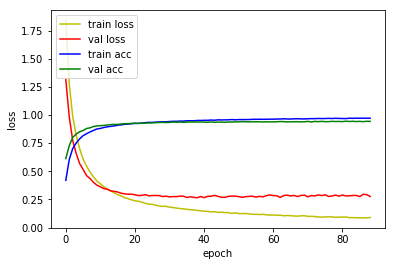

4815/4815 [==============================] - 1s 205us/sample - loss: 0.3258 - acc: 0.9136
Loss: 0.3258422381286185 Accuracy: 0.9136033

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.9698 - acc: 0.3703
Epoch 00001: val_loss improved from inf to 1.32066, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/01-1.3207.hdf5
36805/36805 [==============================] - 13s 367us/sample - loss: 1.9693 - acc: 0.3704 - val_loss: 1.3207 - val_acc: 0.6212
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2753 - acc: 0.6040
Epoch 00002: val_loss improved from 1.32066 to 0.88193, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/02-0.8819.hdf5
36805/36805 [==============================] - 11s 312us/sample - loss: 1.2753 - acc: 0.6040 - val_loss: 0.8819 - val_acc: 0.7577
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.9692 - acc: 0.7026
Epo

36800/36805 [============================>.] - ETA: 0s - loss: 0.2469 - acc: 0.9217
Epoch 00023: val_loss improved from 0.24357 to 0.23941, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/23-0.2394.hdf5
36805/36805 [==============================] - 11s 311us/sample - loss: 0.2469 - acc: 0.9217 - val_loss: 0.2394 - val_acc: 0.9320
Epoch 24/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2422 - acc: 0.9229
Epoch 00024: val_loss improved from 0.23941 to 0.23589, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/24-0.2359.hdf5
36805/36805 [==============================] - 11s 308us/sample - loss: 0.2421 - acc: 0.9229 - val_loss: 0.2359 - val_acc: 0.9350
Epoch 25/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2380 - acc: 0.9240
Epoch 00025: val_loss improved from 0.23589 to 0.22804, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/25-0.2280.hdf5
36805/36805 [==============================] - 11s 310us/sam

36800/36805 [============================>.] - ETA: 0s - loss: 0.1480 - acc: 0.9514
Epoch 00048: val_loss did not improve from 0.19354
36805/36805 [==============================] - 11s 305us/sample - loss: 0.1480 - acc: 0.9514 - val_loss: 0.1994 - val_acc: 0.9464
Epoch 49/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1409 - acc: 0.9533
Epoch 00049: val_loss improved from 0.19354 to 0.19018, saving model to model/checkpoint/2D_CNN_4_only_conv_checkpoint/49-0.1902.hdf5
36805/36805 [==============================] - 11s 309us/sample - loss: 0.1408 - acc: 0.9533 - val_loss: 0.1902 - val_acc: 0.9481
Epoch 50/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9529
Epoch 00050: val_loss did not improve from 0.19018
36805/36805 [==============================] - 11s 307us/sample - loss: 0.1413 - acc: 0.9529 - val_loss: 0.1925 - val_acc: 0.9490
Epoch 51/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1384 - acc: 0.9544

Epoch 77/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1027 - acc: 0.9659
Epoch 00077: val_loss did not improve from 0.17850
36805/36805 [==============================] - 11s 308us/sample - loss: 0.1027 - acc: 0.9659 - val_loss: 0.1990 - val_acc: 0.9548
Epoch 78/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.1056 - acc: 0.9649
Epoch 00078: val_loss did not improve from 0.17850
36805/36805 [==============================] - 11s 305us/sample - loss: 0.1054 - acc: 0.9649 - val_loss: 0.2073 - val_acc: 0.9504
Epoch 79/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9679
Epoch 00079: val_loss did not improve from 0.17850
36805/36805 [==============================] - 11s 306us/sample - loss: 0.0982 - acc: 0.9678 - val_loss: 0.1911 - val_acc: 0.9525
Epoch 80/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0949 - acc: 0.9690
Epoch 00080: val_loss did not improve from 0.17850
36805/36805 [=====

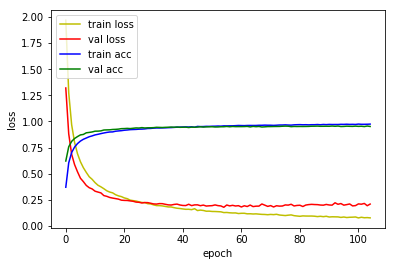

4815/4815 [==============================] - 1s 270us/sample - loss: 0.2652 - acc: 0.9313
Loss: 0.2652070475825392 Accuracy: 0.9312565



ValueError: Negative dimension size caused by subtracting 5 from 3 for 'conv2d_24/Conv2D' (op: 'Conv2D') with input shapes: [?,13,3,64], [5,5,64,128].

In [12]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_DO'.format(i)
    model = build_2d_cnn_only_conv(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print('{} Only Conv Model'.format(i))
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [14]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_DO'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_1_only_conv_DO Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 253, 95, 8)        208       
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 127, 48, 8)        0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 48768)             0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 48768)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                780304    
Total params: 780,512
Trainable params: 780,512
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 1s 280us/sample - loss: 1.1291 - acc: 0.7078
Loss: 1.129059188